In [1]:
import os
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats

import tensorflow.keras as keras
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
screens = ['Focus', 'Mathisis', 'Memoria', 'Reacton', 'Speedy']
screens_code = ['1', '2', '3', '4', '5']

base_path = "C:/Users/SouthSystem/Federated Learning/DataBioCom/data"
phone_accel_file_paths = []
phone_gyro_file_paths = []

for directories, subdirectories, files in os.walk(base_path):
    for filename in files:
        if "accel" in filename:
            phone_accel_file_paths.append(f"{base_path}/accel/{filename}")
            
data = pd.concat(map(pd.read_csv, phone_accel_file_paths))

In [3]:
data

,x_accel,y_accel,z_accel,screen,player_id,timestamp
0,-0.146046,0.802520,0.586626,MemoriaGame - 1.1.1,06mdn3c,1536502712738
1,-0.031261,0.766375,0.666243,MemoriaGame - 1.1.1,06mdn3c,1536502712738
2,-0.042495,0.769794,0.647682,MemoriaGame - 1.1.1,06mdn3c,1536502712738
3,-0.025888,0.766375,0.647194,MemoriaGame - 1.1.1,06mdn3c,1536502712738
4,-0.028818,0.760025,0.643286,MemoriaGame - 1.1.1,06mdn3c,1536502712738
...,...,...,...,...,...,...
466372,-0.038849,-0.608170,-0.793686,FocusGame - 4.1.1,x8rbf3x,1547393235756
466373,-0.042145,-0.613846,-0.786880,FocusGame - 4.1.1,x8rbf3x,1547393235756
466374,-0.043121,-0.613129,-0.786621,FocusGame - 4.1.1,x8rbf3x,1547393235756
466375,-0.042694,-0.608475,-0.789032,FocusGame - 4.1.1,x8rbf3x,1547393235756


In [4]:
users = data['player_id'].unique()

In [5]:
def load_data_1():
    train = np.empty((0, frame_size, 3))
    user_list = []
    frame_size = 500
    step = 50

    for user in users:
        data_user = data[data['player_id']==user]  
        data_user = data_user.iloc[:,[0,1,2]]
        data_user = data_user[500:-500]
        data_user = data_user.values
        data_user = data_user.astype('float32')
        frames = [data_user[i:i+frame_size, :] for i in range(0,data_user.shape[0]-frame_size,step)]
        user_list.extend([user]*len(frames))           
        frames = np.dstack(frames)
        frames = np.rollaxis(frames,-1)
        train = np.vstack((train, frames))
        

    return train, user_list

In [6]:
def load_data_2():
    train = []
    frame_size = 500
    step = 50

    for user in users:
        data_user = data[data['player_id']==user]  
        data_user = data_user.iloc[:,[0,1,2]]
        for w in range(0, data_user.shape[0] - frame_size, step):
            end = w + frame_size        
            frame = data_user.iloc[w:end,[0, 1, 2]]        
            train.append(frame)

    return train

In [5]:
def load_data_3():
    data['session'] = data['player_id'] + "_" + data['timestamp'].apply(str)
    
    counts = data['session'].value_counts()
    counts = counts[counts >= 128]
    counts_list = list(counts.keys())
    df = data[data.session.isin(counts_list) == True]
    
    for idx, val in enumerate(screens):
        df.loc[df.screen.str.contains(screens[idx]), 'screen'] = screens_code[idx]
        
    win_count = 0
    total_win_count = 0
    range_screen = range(1, 6)
    raw_signal = df
    axis_list = ['x_accel', 'y_accel', 'z_accel']
    user_list = []
    window_size = 128
    axis_dict = {}

    for axis in axis_list:  
        features_one = []
        for class_label in range_screen:   
            screen_ID = screens_code[class_label - 1]    
            raw_data_one_activity = np.array(raw_signal.loc[raw_signal['screen'] == screen_ID, [axis]])
            raw_data_one_activity = pd.DataFrame(raw_data_one_activity)   
            player_id_data = np.array(raw_signal.loc[raw_signal['screen'] == screen_ID, ['player_id']])
            player_id_data = pd.DataFrame(player_id_data)  

            for data_point in range(0, len(raw_data_one_activity), window_size):        
                win_count += 1
                start = data_point
                end = start + window_size
                time_domain_window = raw_data_one_activity[start:end] 

                if (len(time_domain_window) == 128):                
                    features_one.append(time_domain_window)
                    if (axis == 'z_accel'):                    
                        user_list.append(player_id_data[start:end][0].unique()[0])                    

        axis_dict[axis] = features_one
        
    new = (axis_dict[axis_list[0]], axis_dict[axis_list[1]], axis_dict[axis_list[2]])
    new_x = new[0]
    new_x = np.asarray(new_x)
    new_x = new_x.reshape(28473,-1)
    print(new_x.shape)

    new_y = new[1]
    new_y = np.asarray(new_y)
    new_y = new_y.reshape(28473,-1)
    print(new_y.shape)

    new_z = new[2]
    new_z = np.asarray(new_z)
    new_z = new_z.reshape(28473,-1)
    print(new_z.shape)
    
    data_join = pd.DataFrame(np.concatenate((new_x, new_y, new_z), axis=1))
    data_join['user'] = user_list
    
    return data_join

In [6]:
def normalize_rows(df):
    array = df.values    
    nsamples, nfeatures = array.shape
    nfeatures = nfeatures - 1
    X = array[:, 0:nfeatures]
    y = array[:, -1]
    
    rows, cols = X.shape
    
    for i in range(0, rows):
        row = X[i,:]
        mu = np.mean( row )
        sigma = np.std( row )
        if( sigma == 0 ):
            sigma = 0.0001
        X[i,:] = (X[i,:] - mu) / sigma
            
    df = pd.DataFrame( X )
    df['user'] = y 
    return df

def unique(list1):       
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    unique_list.sort()
    return unique_list

def create_userids( df ):
    array = df.values
    y = array[:, -1]
    return unique( y )

def build_fcn(input_shape, nb_classes, file_path, num_filters = 128):
    input_layer = keras.layers.Input(input_shape) 

    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=8, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=2*num_filters, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(num_filters, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics=['categorical_accuracy'])
    learning_rate = 0.0001
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, 
                                                  min_lr=learning_rate)
    
    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True, verbose=1)

    callbacks = [reduce_lr,model_checkpoint]

    return callbacks, model

In [7]:
RANDOM_STATE = 11235
EPOCHS = 500

def train_model(df, model_name = "foo.h5" ):
    userids = create_userids( df )
    nbclasses = len(userids)
    print(nbclasses)
    array = df.values
    nsamples, nfeatures = array.shape
    nfeatures = nfeatures -1 
    X = array[:,0:nfeatures]
    y = array[:,-1]
    
    enc = OneHotEncoder()
    enc.fit(y.reshape(-1,1))
    y = enc.transform(y.reshape(-1, 1)).toarray()
    X = X.reshape(-1, 128, 3)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)
    
    print(X_train.shape)
    print(X_test.shape)
    print(X_val.shape)
    
    mini_batch_size = int(min(X_train.shape[0]/10, 16))    
    filepath = model_name
    
    cb, model = build_fcn((128, 3), nbclasses, filepath)
    
    model.summary()

    X_train = np.asarray(X_train).astype(np.float32)
    X_val = np.asarray(X_val).astype(np.float32)
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    BATCH_SIZE = mini_batch_size
    SHUFFLE_BUFFER_SIZE = 100
    
    train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)
    
    start_time = time.time()
    hist = model.fit(train_ds, 
                      epochs=EPOCHS,
                      verbose=True, 
                      validation_data=val_ds, 
                      callbacks=cb)
    
    hist_df = pd.DataFrame(hist.history) 
    
    print(hist_df)
    
    plot_training(hist, model_name, metrics ='accuracy')
    
    hist_csv_file = 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    duration = time.time() - start_time
    print("Training duration: "+str(duration/60))
    
    # EVALUATION 
    X_test = np.asarray(X_test).astype(np.float32)    
    y_true = np.argmax( y_test, axis=1)
    y_pred = np.argmax( model.predict(X_test), axis=1)
    accuracy = metrics.accuracy_score(y_true, y_pred)     

    _, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

    print(accuracy)
    
    return model

def plot_training(history, model_name, metrics ='loss'):
    # list all data in history
    print(history.history.keys())
    keys = list(history.history.keys())
    plt.figure()
    if( metrics == 'loss'):
        plt.plot(history.history[keys[0]])
        plt.plot(history.history[keys[2]])
        plt.title('Model loss ' + model_name)
        plt.ylabel('loss')
    
    if( metrics == 'accuracy'):
        plt.plot(history.history[keys[1]])
        plt.plot(history.history[keys[3]])
        plt.title('Model accuracy '+model_name)
        plt.ylabel('accuracy')
    

    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

In [8]:
def scale_data(data):
    """ Normalizes the data using StandardScaler() function """
    
    data = data.drop(["screen", "timestamp"], axis = 1).copy()
    
    data.columns = ['X', 'Y', 'Z', 'User']
        
    le = LabelEncoder()
    data['s'] = le.fit_transform(data['User'])
    
    X = data[['X', 'Y', 'Z']]
    y = data['User']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    scaled_df = pd.DataFrame(data = X, columns = ['X', 'Y', 'Z'])
    scaled_df['User'] = y.values
    
    return scaled_df

frequency = 100 # Based on Hertz
time_period = 2 # Based on Second
frame_size = frequency * time_period
step_size = frame_size # In order not to have an overlap

def get_frames(df):
    n_features = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, step_size):
        x = df['X'].values[i: i + frame_size]
        y = df['Y'].values[i: i + frame_size]
        z = df['Z'].values[i: i + frame_size]
        
        label = stats.mode(df['User'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, frame_size, n_features)
    labels = np.asarray(labels)
    
    print(frames.shape)
    print(labels.shape)

    return frames, labels

In [44]:
train_set_1, user_list1 = load_data_1()
train_set_join_1 = train_set_1.reshape(train_set_1.shape[0], 1500)
data_join = pd.DataFrame(train_set_join_1)
data_join['user'] = user_list1
data_join.shape

NameError: name 'load_data_1' is not defined

In [ ]:
train_set_2 = load_data_2()

In [9]:
train_set_3 = load_data_3()

C:\Users\SouthSystem\anaconda3\envs\python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


ValueError: cannot copy sequence with size 128 to array axis with dimension 1

In [91]:
train_set_2 = np.asarray(train_set_2)
train_set_join_2 = train_set_2.reshape(train_set_2.shape[0], 1500)

In [13]:
processed_data = scale_data(data)

In [21]:
data_frames, labels = get_frames(processed_data)

(20070, 200, 3)
(20070,)


In [24]:
data_frames_join = data_frames.reshape(data_frames.shape[0], 600)
data_join = pd.DataFrame(data_frames_join)
data_join['user'] = labels
data_join.shape

(20070, 601)

In [33]:
df_idnet = data_join

In [12]:
df_idnet = normalize_rows(train_set_3)
df_idnet

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,user
0,-1.293993,-1.270594,-1.269217,-1.27197,-1.288488,-1.305005,-1.281605,-1.251323,-1.258206,-1.299499,...,1.168471,1.121672,1.079002,1.083131,1.069367,1.063861,0.440331,0.996415,1.070744,06mdn3c
1,-1.594835,-1.609775,-1.545532,-1.521627,-1.494734,-1.508181,-1.58587,-1.476806,-1.428997,-1.10778,...,0.924107,1.00329,0.901696,0.942035,0.927095,0.968928,1.054088,1.333472,1.037653,06mdn3c
2,-1.178501,-1.5472,-2.036037,-2.140985,-1.650767,-1.440871,-1.450538,-1.46987,-1.497488,-1.420158,...,0.8887,0.931508,0.931508,0.93427,1.026789,0.833464,0.968792,0.894224,0.885938,06mdn3c
3,-1.409391,-1.409391,-1.424615,-1.424615,-1.493812,-1.493812,-1.463365,-1.452294,-1.406623,-1.43707,...,0.955774,1.024971,1.00698,1.00006,1.026355,1.038811,1.030507,1.048498,0.946086,06mdn3c
4,-1.280293,-1.419168,-1.361191,-1.345011,-1.323439,-1.315349,-1.33827,-1.33827,-1.382764,-1.362539,...,0.72598,1.14665,0.910697,1.060358,0.871596,0.906652,0.866203,0.841933,0.903955,06mdn3c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28468,1.300156,1.20367,1.175343,1.223055,1.338397,1.267581,1.448471,1.255321,1.348311,1.185656,...,-1.090988,-0.84592,-0.744521,-0.759348,-0.570712,-1.009859,-1.29839,-0.91979,-1.564481,x8rbf3x
28469,1.3894,1.958652,1.215063,1.933243,1.408469,1.518305,1.421102,1.465151,1.424582,1.460622,...,-1.436361,-0.949868,-0.765615,-0.791883,-0.655827,-0.813287,-0.796221,-0.797174,-0.841557,x8rbf3x
28470,0.923591,1.140215,1.524479,1.243577,1.558449,1.046799,1.362657,0.87381,1.267646,1.185491,...,-0.930874,-1.379324,-1.779729,-1.118315,-1.243212,-0.860308,-1.475883,-2.130212,-1.028794,x8rbf3x
28471,1.129768,1.217355,0.926332,1.456663,1.270451,1.140672,1.387056,1.709188,1.049124,1.035104,...,-1.483254,-1.437012,-1.97166,-1.338877,-1.436968,-1.362421,-0.12258,-0.111186,-1.3796,x8rbf3x


30
(17083, 128, 3)
(5695, 128, 3)
(5695, 128, 3)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 128)          3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 128, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 256)          164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 256)          1024      
_________________________________________________________________
activ

Epoch 20/500
1067/1068 [============================>.] - ETA: 0s - loss: 1.3445 - categorical_accuracy: 0.5773
Epoch 00020: val_loss did not improve from 1.53076
1068/1068 [==============================] - 58s 54ms/step - loss: 1.3444 - categorical_accuracy: 0.5774 - val_loss: 1.5630 - val_categorical_accuracy: 0.5471
Epoch 21/500
1068/1068 [==============================] - ETA: 0s - loss: 1.3248 - categorical_accuracy: 0.5844
Epoch 00021: val_loss did not improve from 1.53076
1068/1068 [==============================] - 57s 53ms/step - loss: 1.3248 - categorical_accuracy: 0.5844 - val_loss: 1.7314 - val_categorical_accuracy: 0.4646
Epoch 22/500
1067/1068 [============================>.] - ETA: 0s - loss: 1.3221 - categorical_accuracy: 0.5859
Epoch 00022: val_loss did not improve from 1.53076
1068/1068 [==============================] - 53s 50ms/step - loss: 1.3221 - categorical_accuracy: 0.5858 - val_loss: 1.7578 - val_categorical_accuracy: 0.4625
Epoch 23/500
1067/1068 [==========

Epoch 71/500
1068/1068 [==============================] - ETA: 0s - loss: 0.8701 - categorical_accuracy: 0.7193
Epoch 00071: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.8701 - categorical_accuracy: 0.7193 - val_loss: 1.7841 - val_categorical_accuracy: 0.4859
Epoch 72/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.8542 - categorical_accuracy: 0.7270
Epoch 00072: val_loss did not improve from 1.30043
1068/1068 [==============================] - 56s 53ms/step - loss: 0.8542 - categorical_accuracy: 0.7270 - val_loss: 1.5715 - val_categorical_accuracy: 0.5243
Epoch 73/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.8507 - categorical_accuracy: 0.7309
Epoch 00073: val_loss did not improve from 1.30043
1068/1068 [==============================] - 61s 57ms/step - loss: 0.8508 - categorical_accuracy: 0.7308 - val_loss: 2.7684 - val_categorical_accuracy: 0.3802
Epoch 74/500
1068/1068 [==========

Epoch 97/500
1068/1068 [==============================] - ETA: 0s - loss: 0.6821 - categorical_accuracy: 0.7835
Epoch 00097: val_loss did not improve from 1.30043
1068/1068 [==============================] - 53s 50ms/step - loss: 0.6821 - categorical_accuracy: 0.7835 - val_loss: 1.5045 - val_categorical_accuracy: 0.6086
Epoch 98/500
1068/1068 [==============================] - ETA: 0s - loss: 0.6745 - categorical_accuracy: 0.7853
Epoch 00098: val_loss did not improve from 1.30043
1068/1068 [==============================] - 54s 50ms/step - loss: 0.6745 - categorical_accuracy: 0.7853 - val_loss: 1.9440 - val_categorical_accuracy: 0.4896
Epoch 99/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.6804 - categorical_accuracy: 0.7868
Epoch 00099: val_loss did not improve from 1.30043
1068/1068 [==============================] - 52s 49ms/step - loss: 0.6805 - categorical_accuracy: 0.7868 - val_loss: 2.1943 - val_categorical_accuracy: 0.4918
Epoch 100/500
1067/1068 [=========

1068/1068 [==============================] - ETA: 0s - loss: 0.3865 - categorical_accuracy: 0.8834
Epoch 00147: val_loss did not improve from 1.30043
1068/1068 [==============================] - 54s 51ms/step - loss: 0.3865 - categorical_accuracy: 0.8834 - val_loss: 1.7331 - val_categorical_accuracy: 0.6181
Epoch 148/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.3866 - categorical_accuracy: 0.8810
Epoch 00148: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.3865 - categorical_accuracy: 0.8811 - val_loss: 1.6512 - val_categorical_accuracy: 0.6367
Epoch 149/500
1068/1068 [==============================] - ETA: 0s - loss: 0.3850 - categorical_accuracy: 0.8812
Epoch 00149: val_loss did not improve from 1.30043
1068/1068 [==============================] - 59s 55ms/step - loss: 0.3850 - categorical_accuracy: 0.8812 - val_loss: 1.9712 - val_categorical_accuracy: 0.5371
Epoch 150/500
1067/1068 [====================

Epoch 173/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2968 - categorical_accuracy: 0.9137
Epoch 00173: val_loss did not improve from 1.30043
1068/1068 [==============================] - 58s 54ms/step - loss: 0.2969 - categorical_accuracy: 0.9137 - val_loss: 1.7789 - val_categorical_accuracy: 0.6083
Epoch 174/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2999 - categorical_accuracy: 0.9109
Epoch 00174: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.2998 - categorical_accuracy: 0.9110 - val_loss: 1.5508 - val_categorical_accuracy: 0.6534
Epoch 175/500
1068/1068 [==============================] - ETA: 0s - loss: 0.3023 - categorical_accuracy: 0.9104
Epoch 00175: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.3023 - categorical_accuracy: 0.9104 - val_loss: 1.5275 - val_categorical_accuracy: 0.6644
Epoch 176/500
1068/1068 [======

1068/1068 [==============================] - ETA: 0s - loss: 0.2376 - categorical_accuracy: 0.9299
Epoch 00223: val_loss did not improve from 1.30043
1068/1068 [==============================] - 50s 47ms/step - loss: 0.2376 - categorical_accuracy: 0.9299 - val_loss: 1.5504 - val_categorical_accuracy: 0.6760
Epoch 224/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2362 - categorical_accuracy: 0.9318
Epoch 00224: val_loss did not improve from 1.30043
1068/1068 [==============================] - 50s 47ms/step - loss: 0.2361 - categorical_accuracy: 0.9318 - val_loss: 1.5576 - val_categorical_accuracy: 0.6788
Epoch 225/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2290 - categorical_accuracy: 0.9333
Epoch 00225: val_loss did not improve from 1.30043
1068/1068 [==============================] - 50s 47ms/step - loss: 0.2291 - categorical_accuracy: 0.9332 - val_loss: 1.5987 - val_categorical_accuracy: 0.6655
Epoch 226/500
1067/1068 [====================

Epoch 249/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2183 - categorical_accuracy: 0.9355
Epoch 00249: val_loss did not improve from 1.30043
1068/1068 [==============================] - 49s 46ms/step - loss: 0.2186 - categorical_accuracy: 0.9354 - val_loss: 1.6314 - val_categorical_accuracy: 0.6715
Epoch 250/500
1068/1068 [==============================] - ETA: 0s - loss: 0.2183 - categorical_accuracy: 0.9369
Epoch 00250: val_loss did not improve from 1.30043
1068/1068 [==============================] - 49s 46ms/step - loss: 0.2183 - categorical_accuracy: 0.9369 - val_loss: 1.6434 - val_categorical_accuracy: 0.6716
Epoch 251/500
1068/1068 [==============================] - ETA: 0s - loss: 0.2195 - categorical_accuracy: 0.9368
Epoch 00251: val_loss did not improve from 1.30043
1068/1068 [==============================] - 50s 46ms/step - loss: 0.2195 - categorical_accuracy: 0.9368 - val_loss: 1.6581 - val_categorical_accuracy: 0.6720
Epoch 252/500
1068/1068 [======

Epoch 275/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2041 - categorical_accuracy: 0.9422
Epoch 00275: val_loss did not improve from 1.30043
1068/1068 [==============================] - 59s 55ms/step - loss: 0.2045 - categorical_accuracy: 0.9420 - val_loss: 1.6447 - val_categorical_accuracy: 0.6745
Epoch 276/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2031 - categorical_accuracy: 0.9417
Epoch 00276: val_loss did not improve from 1.30043
1068/1068 [==============================] - 51s 48ms/step - loss: 0.2031 - categorical_accuracy: 0.9417 - val_loss: 1.6780 - val_categorical_accuracy: 0.6739
Epoch 277/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.2038 - categorical_accuracy: 0.9411
Epoch 00277: val_loss did not improve from 1.30043
1068/1068 [==============================] - 59s 55ms/step - loss: 0.2038 - categorical_accuracy: 0.9411 - val_loss: 1.6578 - val_categorical_accuracy: 0.6734
Epoch 278/500
1067/1068 [======

Epoch 301/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1895 - categorical_accuracy: 0.9456
Epoch 00301: val_loss did not improve from 1.30043
1068/1068 [==============================] - 56s 53ms/step - loss: 0.1895 - categorical_accuracy: 0.9456 - val_loss: 1.6704 - val_categorical_accuracy: 0.6730
Epoch 302/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1930 - categorical_accuracy: 0.9440
Epoch 00302: val_loss did not improve from 1.30043
1068/1068 [==============================] - 55s 51ms/step - loss: 0.1930 - categorical_accuracy: 0.9440 - val_loss: 1.6788 - val_categorical_accuracy: 0.6697
Epoch 303/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1914 - categorical_accuracy: 0.9463
Epoch 00303: val_loss did not improve from 1.30043
1068/1068 [==============================] - 55s 52ms/step - loss: 0.1917 - categorical_accuracy: 0.9463 - val_loss: 1.6753 - val_categorical_accuracy: 0.6785
Epoch 304/500
1067/1068 [======

Epoch 327/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1825 - categorical_accuracy: 0.9470
Epoch 00327: val_loss did not improve from 1.30043
1068/1068 [==============================] - 56s 52ms/step - loss: 0.1825 - categorical_accuracy: 0.9470 - val_loss: 1.7271 - val_categorical_accuracy: 0.6737
Epoch 328/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1777 - categorical_accuracy: 0.9494
Epoch 00328: val_loss did not improve from 1.30043
1068/1068 [==============================] - 56s 53ms/step - loss: 0.1777 - categorical_accuracy: 0.9494 - val_loss: 1.7232 - val_categorical_accuracy: 0.6720
Epoch 329/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1772 - categorical_accuracy: 0.9500
Epoch 00329: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 54ms/step - loss: 0.1771 - categorical_accuracy: 0.9501 - val_loss: 1.7040 - val_categorical_accuracy: 0.6764
Epoch 330/500
1067/1068 [======

Epoch 378/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1637 - categorical_accuracy: 0.9555
Epoch 00378: val_loss did not improve from 1.30043
1068/1068 [==============================] - 81s 76ms/step - loss: 0.1637 - categorical_accuracy: 0.9555 - val_loss: 1.8155 - val_categorical_accuracy: 0.6692
Epoch 379/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1629 - categorical_accuracy: 0.9522
Epoch 00379: val_loss did not improve from 1.30043
1068/1068 [==============================] - 83s 77ms/step - loss: 0.1629 - categorical_accuracy: 0.9522 - val_loss: 1.7658 - val_categorical_accuracy: 0.6690
Epoch 380/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1613 - categorical_accuracy: 0.9546
Epoch 00380: val_loss did not improve from 1.30043
1068/1068 [==============================] - 74s 69ms/step - loss: 0.1614 - categorical_accuracy: 0.9545 - val_loss: 1.7840 - val_categorical_accuracy: 0.6713
Epoch 381/500
1067/1068 [======

1067/1068 [============================>.] - ETA: 0s - loss: 0.1514 - categorical_accuracy: 0.9592
Epoch 00428: val_loss did not improve from 1.30043
1068/1068 [==============================] - 64s 60ms/step - loss: 0.1514 - categorical_accuracy: 0.9592 - val_loss: 1.8494 - val_categorical_accuracy: 0.6657
Epoch 429/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1512 - categorical_accuracy: 0.9552
Epoch 00429: val_loss did not improve from 1.30043
1068/1068 [==============================] - 62s 58ms/step - loss: 0.1513 - categorical_accuracy: 0.9552 - val_loss: 1.8365 - val_categorical_accuracy: 0.6650
Epoch 430/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1477 - categorical_accuracy: 0.9583
Epoch 00430: val_loss did not improve from 1.30043
1068/1068 [==============================] - 58s 54ms/step - loss: 0.1477 - categorical_accuracy: 0.9583 - val_loss: 1.8643 - val_categorical_accuracy: 0.6685
Epoch 431/500
1067/1068 [====================

Epoch 454/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1444 - categorical_accuracy: 0.9590
Epoch 00454: val_loss did not improve from 1.30043
1068/1068 [==============================] - 54s 51ms/step - loss: 0.1444 - categorical_accuracy: 0.9590 - val_loss: 1.8911 - val_categorical_accuracy: 0.6699
Epoch 455/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1400 - categorical_accuracy: 0.9605
Epoch 00455: val_loss did not improve from 1.30043
1068/1068 [==============================] - 54s 51ms/step - loss: 0.1401 - categorical_accuracy: 0.9604 - val_loss: 1.8806 - val_categorical_accuracy: 0.6623
Epoch 456/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1402 - categorical_accuracy: 0.9612
Epoch 00456: val_loss did not improve from 1.30043
1068/1068 [==============================] - 55s 51ms/step - loss: 0.1402 - categorical_accuracy: 0.9612 - val_loss: 1.9332 - val_categorical_accuracy: 0.6585
Epoch 457/500
1067/1068 [======

Epoch 480/500
1067/1068 [============================>.] - ETA: 0s - loss: 0.1363 - categorical_accuracy: 0.9599
Epoch 00480: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.1363 - categorical_accuracy: 0.9598 - val_loss: 1.9054 - val_categorical_accuracy: 0.6639
Epoch 481/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1406 - categorical_accuracy: 0.9612
Epoch 00481: val_loss did not improve from 1.30043
1068/1068 [==============================] - 57s 53ms/step - loss: 0.1406 - categorical_accuracy: 0.9612 - val_loss: 1.8971 - val_categorical_accuracy: 0.6616
Epoch 482/500
1068/1068 [==============================] - ETA: 0s - loss: 0.1341 - categorical_accuracy: 0.9631
Epoch 00482: val_loss did not improve from 1.30043
1068/1068 [==============================] - 59s 55ms/step - loss: 0.1341 - categorical_accuracy: 0.9631 - val_loss: 1.8903 - val_categorical_accuracy: 0.6671
Epoch 483/500
1067/1068 [======

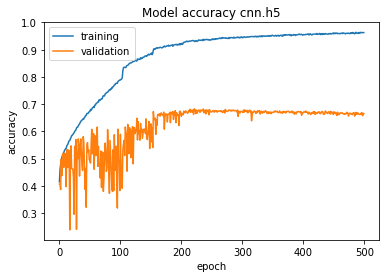

Training duration: 468.1839641610781


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [14]:
model_name = "cnn.h5"
model = train_model(df_idnet, model_name)